In [1]:
import pandas as pd
from sklearn import model_selection
from datetime import datetime
import numpy as np
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import KNNBasic
from surprise import SVDpp
from surprise import SlopeOne
from surprise import accuracy
from surprise.model_selection import GridSearchCV
import matplotlib.pyplot as plt

## Data Loading

In [2]:
df = pd.read_json('Digital_Music_5.json', lines=True)
df.head()

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
0,5,3.0,True,"06 3, 2013",A2TYZ821XXK2YZ,3426958910,{'Format:': ' Audio CD'},Garrett,"This is awesome to listen to, A must-have for ...",Slayer Rules!,1370217600,NaN
1,5,NaN,True,"10 11, 2014",A3OFSREZADFUDY,3426958910,{'Format:': ' Audio CD'},Ad,bien,Five Stars,1412985600,NaN
2,5,NaN,True,"02 11, 2014",A2VAMODP8M77NG,3426958910,{'Format:': ' Audio CD'},JTGabq,It was great to hear the old stuff again and I...,SLAYER!!!!!!!!!!!!!!!!!!!!!,1392076800,NaN
3,4,3.0,False,"12 7, 2013",AAKSLZ9IDTEH0,3426958910,{'Format:': ' Audio CD'},john F&#039;n doe,well best of's are a bit poison normally but t...,slayer greatest hits! you mean everything righ...,1386374400,NaN
4,5,NaN,True,"06 12, 2016",A3OH43OZJLKI09,5557706259,{'Format:': ' Audio CD'},melinda a goodman,What can I say? This is Casting Crowns!!!This ...,"This is a good, blessing filled",1465689600,NaN


In [5]:
df.groupby('reviewerID').count().min()

overall           1
vote              0
verified          1
reviewTime        1
asin              1
style             0
reviewerName      0
reviewText        0
summary           0
unixReviewTime    1
image             0
dtype: int64

In [34]:
df.shape

(169781, 12)

In [3]:
df['unixReviewTime'] = df['unixReviewTime'].map(lambda x: datetime.fromtimestamp(x))

count                           169781
mean     2014-11-23 17:10:10.287370240
min                1998-07-08 17:00:00
25%                2013-12-12 16:00:00
50%                2015-01-19 16:00:00
75%                2016-02-09 16:00:00
max                2018-09-25 17:00:00
Name: unixReviewTime, dtype: object


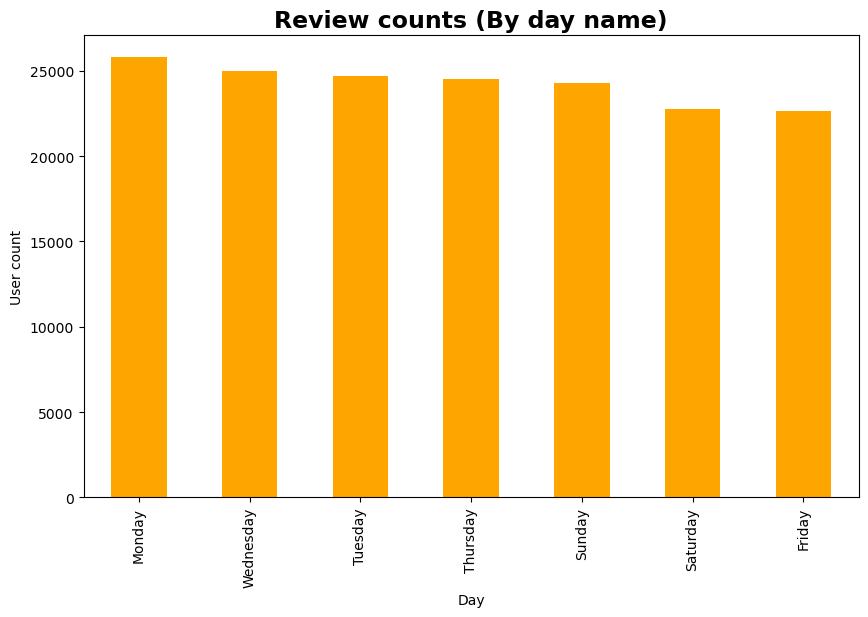

In [39]:
print(df['unixReviewTime'].describe(datetime_is_numeric=True))

df['unixReviewTime'].dt.day_name().value_counts().plot.bar(color='orange',figsize=(10,6))
plt.title("Review counts (By day name)",fontweight='bold',fontsize=17)
plt.xlabel("Day")
plt.ylabel("User count")
plt.savefig('review_counts_by_day_name.png')
plt.show()

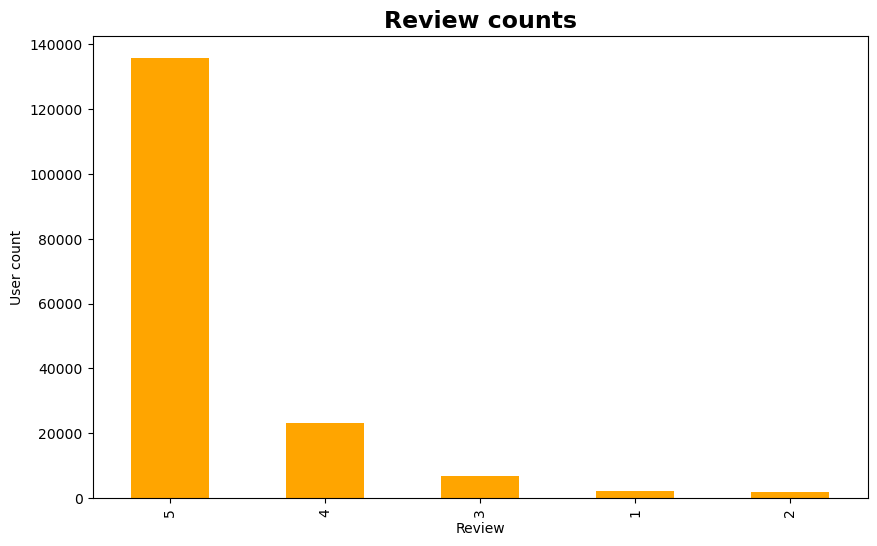

In [40]:
df.overall.value_counts().plot.bar(figsize=(10,6),color='orange')
plt.title("Review counts",fontweight='bold',fontsize=17)
plt.xlabel("Review")
plt.ylabel("User count")
plt.savefig('review_count_by_rating.png')
plt.show()

In [4]:
df['style'] = df['style'].astype(str)
df['style'] = df['style'].apply(lambda x: x.split(':')[-1].strip(" }'"))

In [5]:
df.head()

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
0,5,3.0,True,"06 3, 2013",A2TYZ821XXK2YZ,3426958910,Audio CD,Garrett,"This is awesome to listen to, A must-have for ...",Slayer Rules!,2013-06-02 17:00:00,NaN
1,5,NaN,True,"10 11, 2014",A3OFSREZADFUDY,3426958910,Audio CD,Ad,bien,Five Stars,2014-10-10 17:00:00,NaN
2,5,NaN,True,"02 11, 2014",A2VAMODP8M77NG,3426958910,Audio CD,JTGabq,It was great to hear the old stuff again and I...,SLAYER!!!!!!!!!!!!!!!!!!!!!,2014-02-10 16:00:00,NaN
3,4,3.0,False,"12 7, 2013",AAKSLZ9IDTEH0,3426958910,Audio CD,john F&#039;n doe,well best of's are a bit poison normally but t...,slayer greatest hits! you mean everything righ...,2013-12-06 16:00:00,NaN
4,5,NaN,True,"06 12, 2016",A3OH43OZJLKI09,5557706259,Audio CD,melinda a goodman,What can I say? This is Casting Crowns!!!This ...,"This is a good, blessing filled",2016-06-11 17:00:00,NaN


In [49]:
# df['style'].value_counts().apply(lambda x: x/len(df))

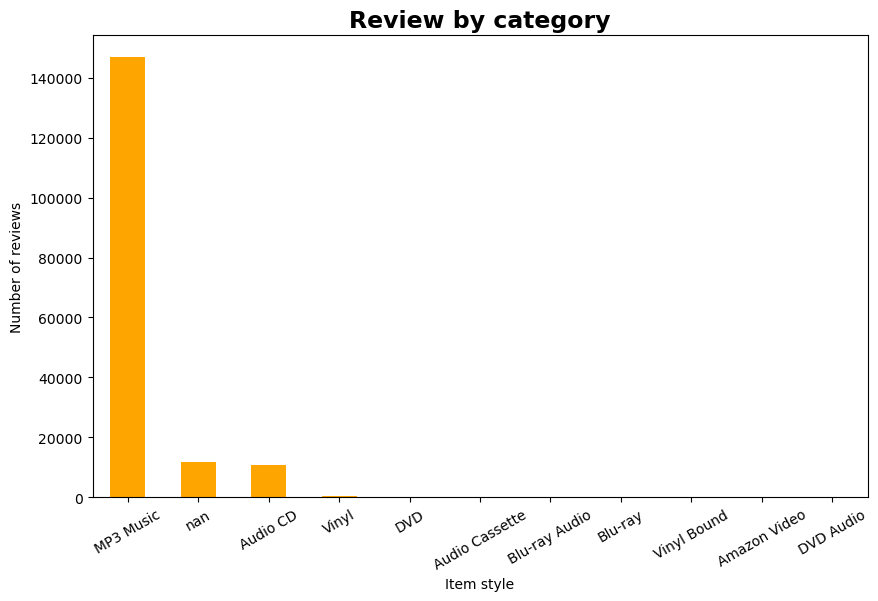

In [56]:
df['style'].value_counts().plot.bar(figsize=(10,6),color='orange')
plt.title("Review by category",fontweight='bold',fontsize=17)
plt.xlabel("Item style")
plt.ylabel("Number of reviews")
plt.xticks(rotation=30)
plt.savefig('num_reveiews_by_category.png')
plt.show()

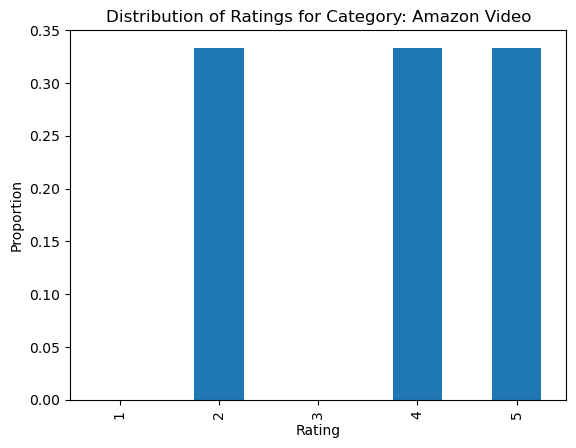

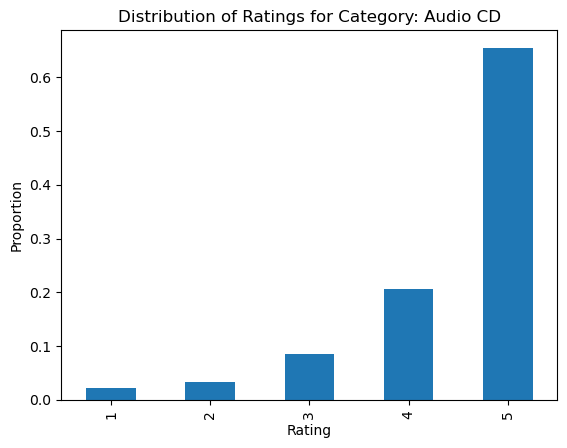

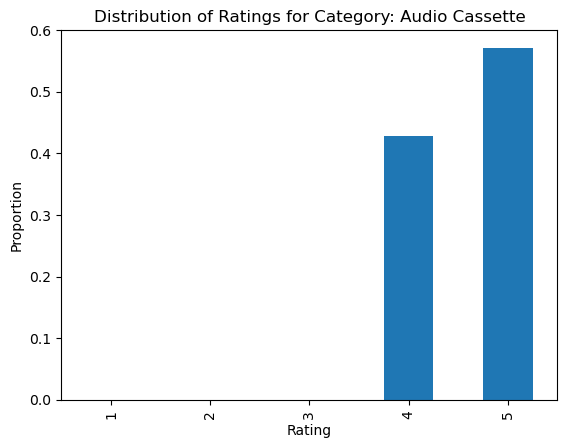

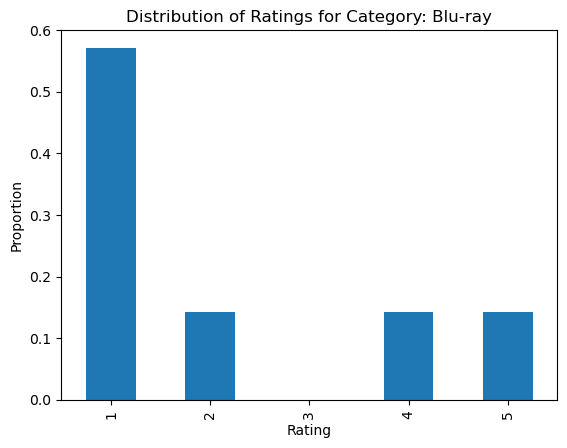

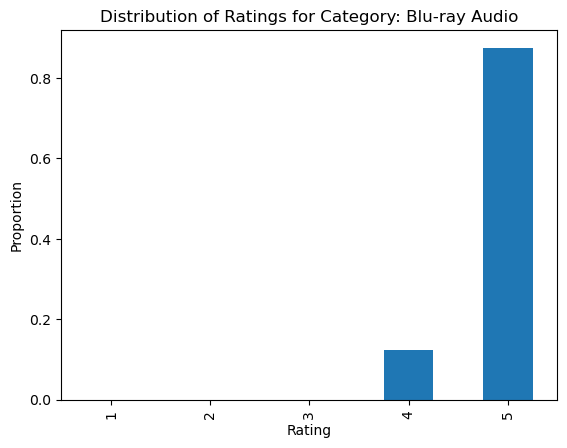

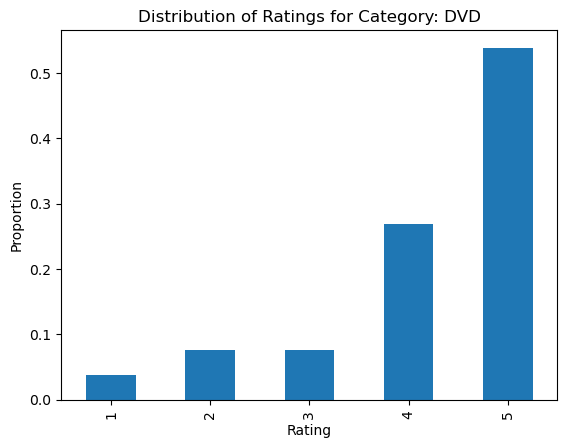

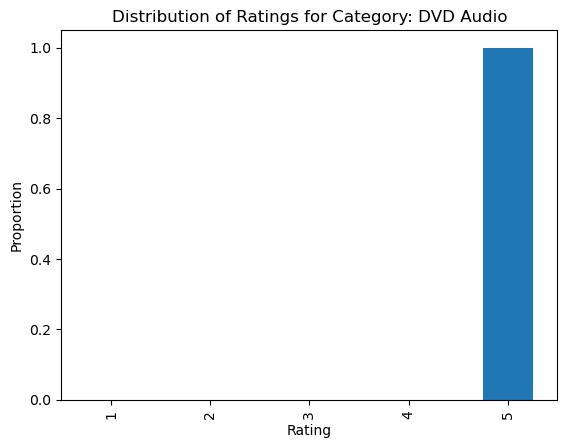

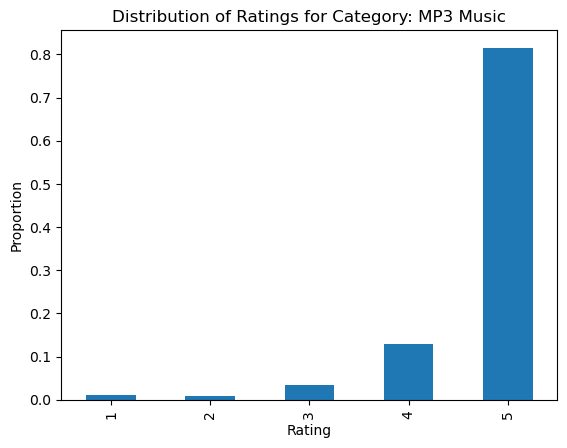

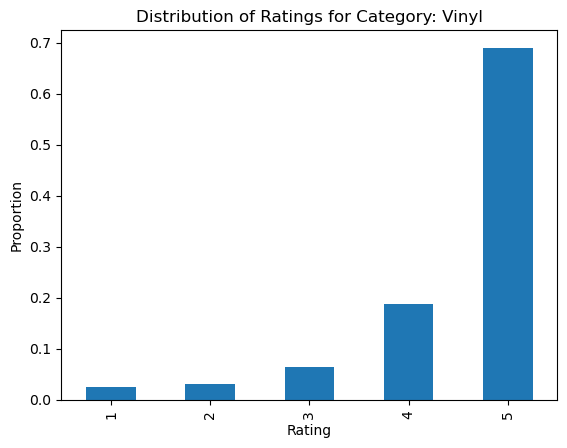

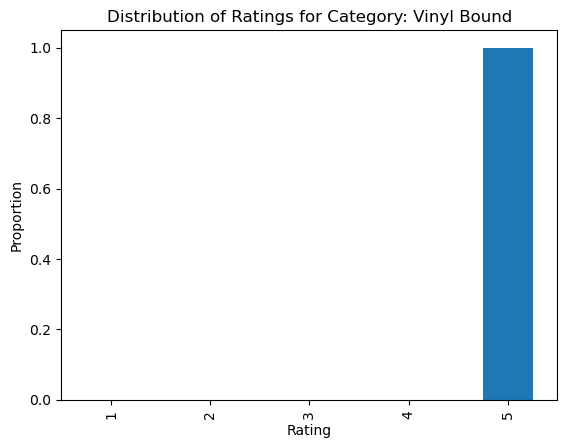

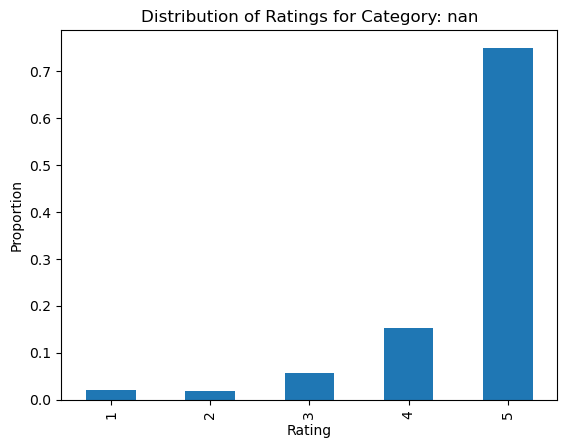

In [43]:
rating_distributions = df.groupby('style')['overall'].value_counts(normalize=True).unstack()
for category in rating_distributions.index:
    plt.figure()
    rating_distributions.loc[category].plot(kind='bar')
    plt.title(f'Distribution of Ratings for Category: {category}')
    plt.xlabel('Rating')
    plt.ylabel('Proportion')
    plt.savefig(f'rating_distribution_{category}.png')
    plt.show()

## KNN Basic Model

In [17]:
reader = Reader(rating_scale=(1, 5))

data = Dataset.load_from_df(df[['reviewerID', 'asin', 'overall']], reader)

trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

param_grid = {'n_epochs': [5, 10, 15], 'lr_all': [0.002, 0.005, 0.01],
              'reg_all': [0.02, 0.04, 0.06]}

gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3)

gs.fit(data)


best_params = gs.best_params['rmse']

print("Best Parameters:", best_params)

best_knn_basic_model = KNNBasic(n_epochs=best_params['n_epochs'], 
                     lr_all=best_params['lr_all'], reg_all=best_params['reg_all'])
# best_knn_basic_model = gs

best_knn_basic_model.fit(trainset)

train_prediction = best_knn_basic_model.test(trainset.build_testset())

test_prediction = best_knn_basic_model.test(testset)

train_rmse = accuracy.rmse(train_prediction)

test_rmse = accuracy.rmse(test_prediction)
print("Train RMSE with Tuned Model:", train_rmse)
print("Test RMSE with Tuned Model:", test_rmse)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

## SVD++ Model

In [16]:
reader = Reader(rating_scale=(1, 5))

data = Dataset.load_from_df(df[['reviewerID', 'asin', 'overall']], reader)

trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

param_grid = {'n_epochs': [5, 10, 15], 'lr_all': [0.002, 0.005, 0.01],
              'reg_all': [0.02, 0.04, 0.06]}

gs = GridSearchCV(SVDpp, param_grid, measures=['rmse'], cv=3)

gs.fit(data)


best_params = gs.best_params['rmse']

print("Best Parameters:", best_params)

best_svd_pp_model = SVDpp(n_epochs=best_params['n_epochs'], 
                     lr_all=best_params['lr_all'], reg_all=best_params['reg_all'])

# best_svd_pp_model = gs
best_svd_pp_model.fit(trainset)

train_prediction = best_svd_pp_model.test(trainset.build_testset())

test_prediction = best_svd_pp_model.test(testset)

train_rmse = accuracy.rmse(train_prediction)

test_rmse = accuracy.rmse(test_prediction)
print("Train RMSE with Tuned Model:", train_rmse)
print("Test RMSE with Tuned Model:", test_rmse)

Best Parameters: {'n_epochs': 15, 'lr_all': 0.01, 'reg_all': 0.02}
RMSE: 0.4068
RMSE: 0.5502
Train RMSE with Tuned Model: 0.40677660198591137
Test RMSE with Tuned Model: 0.550166513026194


## Slope One Model

In [19]:
reader = Reader(rating_scale=(1, 5))

data = Dataset.load_from_df(df[['reviewerID', 'asin', 'overall']], reader)

trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

slope_one_model = SlopeOne()

slope_one_model.fit(trainset)

train_prediction = slope_one_model.test(trainset.build_testset())

test_prediction = slope_one_model.test(testset)

train_rmse = accuracy.rmse(train_prediction)

test_rmse = accuracy.rmse(test_prediction)
print("Train RMSE with Tuned Model:", train_rmse)
print("Test RMSE with Tuned Model:", test_rmse)

RMSE: 0.1107
RMSE: 0.5811
Train RMSE with Tuned Model: 0.11071587358921507
Test RMSE with Tuned Model: 0.5811011878805571


## Baseline

predict using the mean rating for each existing product in the training dataset. If item does not exist, predict with the overall mean rating across the entire training set.

In [20]:
data = df[['reviewerID', 'asin', 'overall']]
trainset, testset = model_selection.train_test_split(data, test_size=0.2, random_state=42)

In [21]:
train_mean = trainset.groupby('asin').mean()
train_mean.head()

,overall
asin,
3426958910,4.750000
5557505946,5.000000
5557706259,4.555556
5559166928,4.875000
7799420340,4.803571


In [22]:
def predict(test):
    overall_mean = trainset['overall'].mean()
    userId, productId, rating = test
    if productId in train_mean.index:
        return train_mean.loc[productId]['overall']
    return overall_mean

In [23]:
def rmse(predicted, expected):
    return np.sqrt(sum((predicted - expected) ** 2) / len(testset))

In [24]:
test_prediction = [predict(i) for iin testset.to_numpy()]

In [25]:
test_prediction = np.array(test_prediction)

In [26]:
test_prediction

array([4.8372093 , 4.86666667, 4.63636364, ..., 5.        , 4.88888889,
       4.4       ])

In [27]:
testset

,reviewerID,asin,overall
89071,A2C2S9BBPWTK9Y,B00CZF8B68,5
131119,AQR5ZB4BIJFLT,B00122Z6ZY,5
116727,A3QEOGJXHI6UEG,B0186SEPNU,5
76480,A18REVWRZ4GA7M,B007JCPEVM,5
160338,A2IJCEG2J34W61,B00E67KLDE,5
...,...,...,...
85246,A3IUDYSAD6LCA4,B00B3EUYAS,5
34762,A2BYV7S1QP2YIG,B0011XCZ1M,4
124658,A2JXX1BAZ19Y4X,B000VRSXHE,3
3248,A2XLYJIQHITC3X,B000THG2K6,5


In [28]:
actual = np.array(testset['overall'].values)

In [29]:
rmse(test_prediction, actual)

0.7063984511780854

In [30]:
actual = np.array(trainset['overall'].values)

In [31]:
train_prediction = np.array([predict(i) for i in trainset.to_numpy()])

In [32]:
rmse(train_prediction, actual)

1.2855086858266391